# LOCALIZACIÓN POR DISTRITOS 

Este *notebook* crea un mapa interactivo para conocer como se distribuyen por distritos las estaciones del servicio *Bicing* de la ciudad de Barcelona.

In [1]:
import pandas as pd
import geopandas as gpd
import json
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import shape, MultiPolygon, Point
from pathlib import Path

from IPython.display import Image
import plotly.io as pio

In [2]:
# Cargar y procesar el GeoJSON
def load_and_process_geojson(filepath):
    with open(filepath, 'r') as file:
        geojson_data = json.load(file)

    features = geojson_data['features']
    geometries = []
    properties = []

    for feature in features:
        geom = shape(feature['geometry'])
        if isinstance(geom, MultiPolygon):
            geom = max(geom.geoms, key=lambda p: p.area)
        geometries.append(geom)
        properties.append(feature['properties'])

    gdf = gpd.GeoDataFrame(properties, geometry=geometries)
    return gdf

# Función para eliminar puntos no asignados a distritos (fuera de la ciudad de Barcelona)
def eliminar_puntos_sin_distrito(localizacion_gdf, districts_gdf):
    # Asignar cada punto al distrito correspondiente
    localizacion_con_distrito = gpd.sjoin(localizacion_gdf, districts_gdf[['Nombre', 'geometry']], how="left", predicate="within")
    localizacion_con_distrito = localizacion_con_distrito.rename(columns={"Nombre": "distrito"})
    
    # Filtrar solo los puntos que tienen distrito asignado
    puntos_con_distrito = localizacion_con_distrito[localizacion_con_distrito['distrito'].notnull()]
    
    return puntos_con_distrito

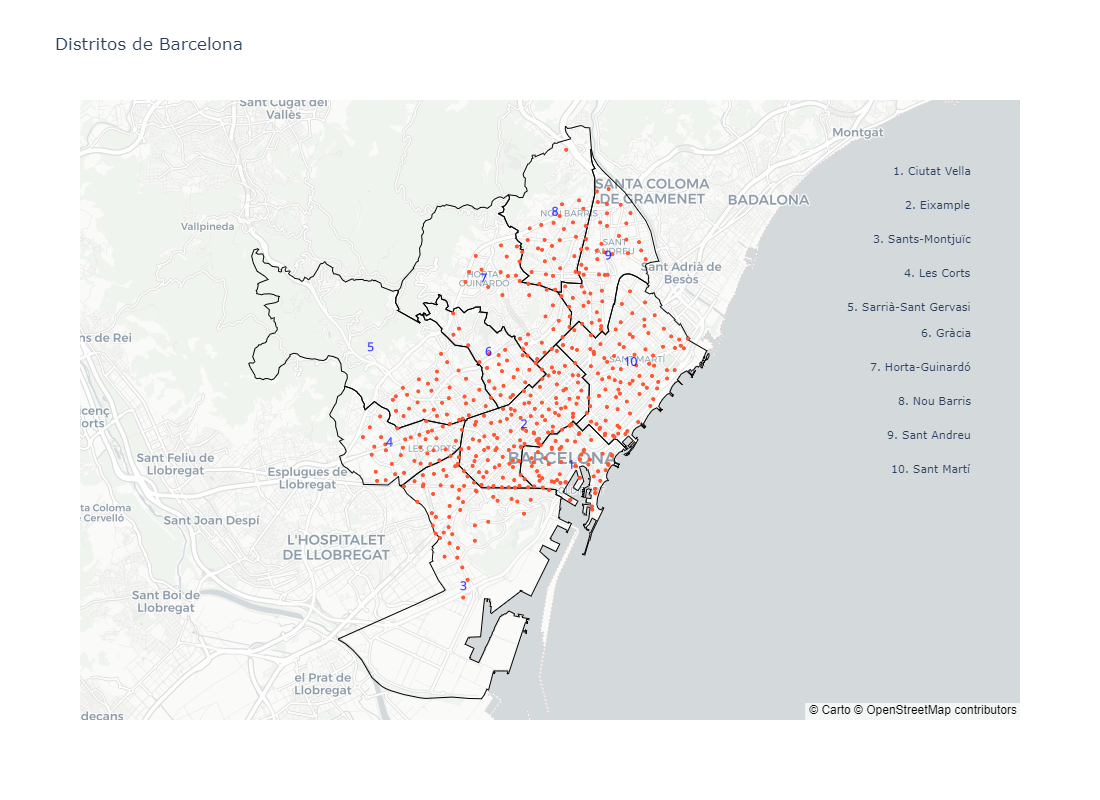

In [3]:
nombres = ['Ciutat Vella', 'Eixample', 'Sants-Montjuïc', 'Les Corts', 
           'Sarrià-Sant Gervasi', 'Gràcia', 'Horta-Guinardó', 
           'Nou Barris', 'Sant Andreu', 'Sant Martí']

localizacion = pd.read_parquet('../../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/GEOLOCALIZACION.parquet')
localizacion.index = localizacion.station_id
localizacion = localizacion[['lat', 'lon']]

geojson_path = '../../../1-DATOS/2-DATOS PROCESADOS/GEOPORTAL/districtes.geojson'
districts_gdf = load_and_process_geojson(geojson_path)

# Añadir el sistema de referencia de coordenadas (CRS) a los distritos
districts_gdf.set_crs(epsg=4326, inplace=True)

# Añadir los nombres a los datos
districts_gdf['Nombre'] = nombres

localizacion_gdf = gpd.GeoDataFrame(
    localizacion,
    geometry=[Point(xy) for xy in zip(localizacion['lon'], localizacion['lat'])],
    crs="EPSG:4326"
)

# Obtener los puntos filtrados
localizacion_con_distrito = eliminar_puntos_sin_distrito(localizacion_gdf, districts_gdf)

# Convertir el GeoDataFrame de distritos a GeoJSON para Plotly
districts_geojson = json.loads(districts_gdf.to_json())

# Crear el mapa 
fig = px.choropleth_mapbox(
    districts_gdf,
    geojson=districts_geojson,
    locations=districts_gdf.index,
    color_discrete_sequence=["rgba(0,0,0,0)"],  #
    hover_name="Nombre", 
    title="Distritos de Barcelona",
)

# Configuración de los detalles del mapa
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=11,
    mapbox_center={"lat": 41.3851+0.01, "lon": 2.1734},
    width=1100,
    height=800
)

fig.update_traces(marker_line_color="black", marker_line_width=1)

# Añadir los puntos de localización 
fig.add_trace(go.Scattermapbox(
    lat=localizacion_con_distrito['lat'],
    lon=localizacion_con_distrito['lon'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=5,
        color='#FF5733'
    ),
    text=localizacion_con_distrito.index.astype(str),
    hoverinfo="text",
    showlegend=False  
))

centroides = []
nom = []
# Añadir los números en los centroides de cada distrito
for idx, row in districts_gdf.iterrows():
    centroid = row['geometry'].centroid
    fig.add_trace(go.Scattermapbox(
        lat=[centroid.y],
        lon=[centroid.x],
        mode='text',
        text=str(idx + 1),  
        textfont=dict(size=12, color="blue"),
        showlegend=False
    ))
    nom.append(row)
    centroides.append(centroid)
    
# Añadir la leyenda con los nombres de los distritos 
fig.update_layout(
    annotations=[
        go.layout.Annotation(
            x=0.95,
            y=0.9 - i * (0.55 / len(nombres)), 
            xref="paper",
            yref="paper",
            text=f"{idx+1}. {nombre}",
            showarrow=False,
            font=dict(size=11)
        )
        for i, (idx, nombre) in enumerate(enumerate(nombres))
    ]
)

#fig.show() # Muestra la imagen en formato interactivo

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática

Se registra el distrito al que pertenece cada estación.

In [4]:
localizacion_con_distrito['station_id'] = localizacion_con_distrito.index
localizacion_con_distrito = localizacion_con_distrito[['station_id', 'lat', 'lon', 'distrito']]
localizacion_con_distrito = localizacion_con_distrito.reset_index(drop=True)
localizacion_con_distrito.to_csv('../../../1-DATOS/3-DATOS DE RESULTADOS/ANALISIS DESCRIPTIVO/localizacion_distritos_estaciones.csv')
localizacion_con_distrito.head(5)

,station_id,lat,lon,distrito
0,1.0,41.397978,2.180107,Eixample
1,2.0,41.395488,2.177198,Eixample
2,3.0,41.394156,2.181331,Eixample
3,4.0,41.393317,2.181248,Eixample
4,5.0,41.391103,2.180176,Ciutat Vella
